In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from typing import *
import numpy as np
from functools import partial
from fastprogress import progress_bar
import pandas as pd
import h5py

from lumin.plotting.results import plot_roc

import torch
from torch import Tensor, nn
import torch.nn.functional as F
from torch._vmap_internals import _vmap as vmap

from tomopt.volume import *
from tomopt.muon import *
from tomopt.inference import *
from tomopt.optimisation import *
from tomopt.core import *
from tomopt.utils import *
from tomopt.plotting import *

import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
with h5py.File('furnace_data_1kmu_1e4_nozero.hdf5', "r") as infile:
    preds = Tensor(infile['preds'][()])
    targs = Tensor(infile['targs'][()])

In [4]:
def get_volume(size: float = 0.1, lwh: Tensor = Tensor([1.0, 1.0, 1.4]), device: torch.device = torch.device("cpu")) -> Volume:
    def area_cost(x: Tensor) -> Tensor:
        return F.relu(x)

    layers: List[Layer] = []
    n_panels = 4
    layers.append(
        PanelDetectorLayer(
            pos="above",
            lw=lwh[:2],
            z=lwh[2].item(),
            size=0.2,
            panels=[
                DetectorPanel(
                    res=1e4,
                    eff=1,
                    init_xyz=(lwh[0].item() / 2, lwh[1].item() / 2, lwh[2].item() - (i * (0.2) / n_panels)),
                    init_xy_span=(4., 4.),
                    area_cost_func=area_cost,
                    device=device,
                )
                for i in range(n_panels)
            ],
        )
    )
    for z in np.round(np.arange(lwh[2] - 0.2, 0.2, -size), decimals=2):
        layers.append(PassiveLayer(lw=lwh[:2], z=z, size=size, device=device))
    layers.append(
        PanelDetectorLayer(
            pos="below",
            lw=lwh[:2],
            z=size,
            size=0.2,
            panels=[
                DetectorPanel(
                    res=1e4,
                    eff=1,
                    init_xyz=(lwh[0].item() / 2, lwh[1].item() / 2, 0.2 - (i * (0.2) / n_panels)),
                    init_xy_span=(4., 4.),
                    area_cost_func=area_cost,
                    device=device,
                )
                for i in range(n_panels)
            ],
        )
    )

    return Volume(nn.ModuleList(layers))

In [5]:
targs.shape

torch.Size([200, 1])

In [6]:
volume = get_volume()

In [7]:
volume

Volume(
  (layers): ModuleList(
    (0): PanelDetectorLayer(
      (panels): ModuleList(
        (0): <class 'tomopt.volume.panel.DetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([1.4000]), and xy span tensor([4., 4.])
        (1): <class 'tomopt.volume.panel.DetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([1.3500]), and xy span tensor([4., 4.])
        (2): <class 'tomopt.volume.panel.DetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([1.3000]), and xy span tensor([4., 4.])
        (3): <class 'tomopt.volume.panel.DetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([1.2500]), and xy span tensor([4., 4.])
      )
    )
    (1): PassiveLayer located at z=tensor([1.2000])
    (2): PassiveLayer located at z=tensor([1.1000])
    (3): PassiveLayer located at z=tensor([1.])
    (4): PassiveLayer located at z=tensor([0.9000])
    (5): PassiveLayer located at z=tensor([0.8000])
    (6): PassiveLayer located at z=tensor([0.7000])
    (

# Vars

In [8]:
df = pd.DataFrame(targs.numpy(), columns=['gen_target'])

In [9]:
from tomopt.plotting.appearance import *

def plot_pred(pred, targ):
    with sns.axes_style(style="whitegrid", rc={"patch.edgecolor": "none"}):
        fig, axs = plt.subplots(1, len(pred), figsize=(W_MID, H_MID))

        for i in range(len(pred)):
            sns.heatmap(
                pred[i],
                ax=axs[i],
                cmap="viridis",
                square=True,
                cbar=False,
                vmin=np.nanmin(pred),
                vmax=np.nanmax(pred),
            )
        print("Zero-ordered target layer ID (including ladel bottom layer):", np.floor((targ-volume.get_passive_z_range()[0]-volume.passive_size)/volume.passive_size))
        plt.show()

In [10]:
ladel_removed = preds[:,1:,1:-1,1:-1]

In [11]:
def get_3d_avg(data):
    return F.avg_pool3d(data, kernel_size=3, padding=1, stride=1, count_include_pad=False)

In [12]:
def get_3d_gauss(data):
    gauss = nn.Conv3d(1, 1, kernel_size=3, stride=1, padding=1, padding_mode='replicate', bias=False)
    gauss.weight.data =Tensor([[[[[1,2,1],[2,4,2],[1,2,1]],[[2,4,2],[4,8,4],[2,4,2]], [[1,2,1],[2,4,2],[1,2,1]]]]])
    gauss.requires_grad_(False)
    return gauss(data[:,None]).squeeze()/gauss.weight.sum()

In [13]:
def get_layer_avgs(data):
    return data.mean((-1,-2))

In [14]:
def get_max_sub_mean(data):
    maxes = F.max_pool1d(data, kernel_size=3, padding=1, stride=1)
    mins = -F.max_pool1d(-data, kernel_size=3, padding=1, stride=1)
    return maxes-mins

In [15]:
def get_max_div_mean(data):
    maxes = F.max_pool1d(data, kernel_size=3, padding=1, stride=1)
    mins = -F.max_pool1d(-data, kernel_size=3, padding=1, stride=1)
    return maxes/mins

In [16]:
def get_edge_det(data, kernel):
    edge = nn.Conv1d(1, 1, kernel_size=3, stride=1, padding=1, padding_mode='replicate', bias=False)
    edge.weight.data = Tensor([[kernel]])
    edge.requires_grad_(False)
    return edge(data[:,None]).squeeze()

In [17]:
def get_1d_gauss(data):
    gauss = nn.Conv1d(1, 1, kernel_size=3, stride=1, padding=1, padding_mode='replicate', bias=False)
    gauss.weight.data = Tensor([[[2,4,2]]])
    gauss.requires_grad_(False)
    return gauss(data[:,None]).squeeze()/8

In [18]:
def get_1d_avg(data):
    return F.avg_pool1d(data, kernel_size=3, padding=1, stride=1, count_include_pad=False)

In [19]:
def get_probs(data):
    return F.softmax(data, dim=-1)

In [20]:
def targ2class(targs, volume):
    return torch.div((targs-volume.get_passive_z_range()[0]), volume.passive_size, rounding_mode='floor')-1  # -1 due to conversion to layer ID, instead of fill height

In [21]:
def get_losses(probs, class_targs, pred_start, test_id=None):
    ints = torch.arange(pred_start, pred_start+probs.size(1))
    mses = (class_targs-ints).abs()
    mses = 100*mses/mses.sum(-1, keepdim=True)
    losses = mses*probs
    if test_id is not None:
        print('targ ID', class_targs[test_id])
        print('probs', probs[test_id])
        print('ints', ints)
        print('mses', mses[test_id])
        print('int losses', losses[test_id])
    return losses.sum(-1)

In [22]:
ctargs = targ2class(targs, volume)

In [23]:
ctargs.min(), ctargs.max()

(tensor(1.), tensor(8.))

In [29]:
pred_start = 1
ints = torch.arange(pred_start, pred_start+9)
mses = (8-ints).abs()
mses = 100*mses/mses.sum(-1, keepdim=True)
ints, mses

(tensor([1, 2, 3, 4, 5, 6, 7, 8, 9]),
 tensor([24.1379, 20.6897, 17.2414, 13.7931, 10.3448,  6.8966,  3.4483,  0.0000,
          3.4483]))

In [30]:
ints = torch.arange(pred_start, pred_start+9)
mses = (1-ints).abs()
mses = 100*mses/mses.sum(-1, keepdim=True)
ints, mses

(tensor([1, 2, 3, 4, 5, 6, 7, 8, 9]),
 tensor([ 0.0000,  2.7778,  5.5556,  8.3333, 11.1111, 13.8889, 16.6667, 19.4444,
         22.2222]))

start=1 => cut last pred

start=0 => cut first pred

In [34]:
def get_loss(probs, class_targs, pred_start, test_id=None):
    return get_losses(probs, class_targs, pred_start, test_id).mean()

In [35]:
from sklearn.metrics import accuracy_score
from prettytable import PrettyTable

In [36]:
def score_data(logits, targs, pred_starts=(0,1), volume=volume, test_id=None):
    ctargs = targ2class(targs, volume=volume)
    pt = PrettyTable(field_names=['Start', 'Int class loss', ' Acc', 'Fill MSE'])
    for start in pred_starts:
        if start == 0:
            probs = get_probs(logits[:,1:])
            preds = probs.argmax(-1, keepdim=True)+1
        elif start == 1:
            probs = get_probs(logits[:,:-1])
            preds = probs.argmax(-1, keepdim=True)+1
        pred_fill = ((preds+1)*volume.passive_size)+volume.get_passive_z_range()[0]
        true_fill = ((ctargs+1)*volume.passive_size)+volume.get_passive_z_range()[0]
        pt.add_row([start,
                    get_loss(probs, ctargs, start, test_id=test_id).item(),
                    accuracy_score(ctargs, preds).item(),
                    ((true_fill-pred_fill)**2).mean().item()])
    print(pt)

# Tests

In [37]:
test_id=0

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


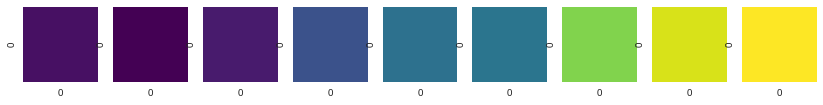

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


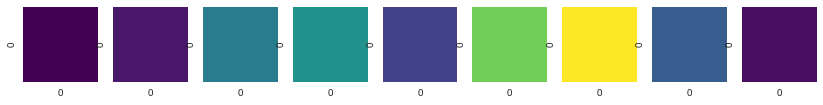

+-------+--------------------+-------+----------------------+
| Start |   Int class loss   |   Acc |       Fill MSE       |
+-------+--------------------+-------+----------------------+
|   0   | 12.490754127502441 |  0.15 | 0.061900001019239426 |
|   1   | 12.497160911560059 | 0.165 |  0.0964999869465828  |
+-------+--------------------+-------+----------------------+


In [38]:
# max-min
x = get_layer_avgs(ladel_removed)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_max_sub_mean(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs)

Zero-ordered target layer ID (including ladel bottom layer): tensor([5.])


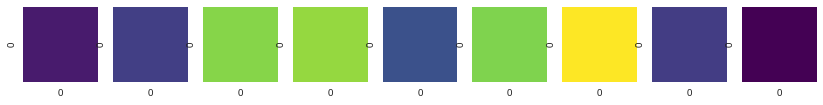

+-------+--------------------+------+----------------------+
| Start |   Int class loss   |  Acc |       Fill MSE       |
+-------+--------------------+------+----------------------+
|   0   | 11.887236595153809 | 0.16 | 0.052449993789196014 |
|   1   | 11.977927207946777 | 0.15 |  0.0669499933719635  |
+-------+--------------------+------+----------------------+


In [39]:
# max/min
x = get_layer_avgs(ladel_removed)
x = get_max_div_mean(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs)

In [ ]:
# pre-avg 3d max-min
x = get_3d_avg(ladel_removed)
plot_pred(x[test_id], targs[test_id])
x = get_layer_avgs(x)
x = get_max_sub_mean(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs)

In [ ]:
# pre-avg 3d max/min
x = get_3d_avg(ladel_removed)
plot_pred(x[test_id], targs[test_id])
x = get_layer_avgs(x)
x = get_max_div_mean(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs)

In [ ]:
# pre-gaiss 3d max-min
x = get_3d_gauss(ladel_removed)
plot_pred(x[test_id], targs[test_id])
x = get_layer_avgs(x)
x = get_max_sub_mean(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs)

In [ ]:
# pre-gauss 3d max/min
x = get_3d_gauss(ladel_removed)
plot_pred(x[test_id], targs[test_id])
x = get_layer_avgs(x)
x = get_max_div_mean(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs)

In [ ]:
# avg 1d max-min
x = get_layer_avgs(ladel_removed)
x = get_1d_avg(x)
x = get_max_sub_mean(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs)

In [ ]:
# avg 1d max/min
x = get_layer_avgs(ladel_removed)
x = get_1d_avg(x)
x = get_max_div_mean(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs)

In [ ]:
# avg 1d max/min
x = get_layer_avgs(ladel_removed)
x = get_1d_avg(x)
x = get_max_div_mean(x)*1e4
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs)

In [ ]:
# gaussg 1d max-min
x = get_layer_avgs(ladel_removed)
x = get_1d_gauss(x)
x = get_max_sub_mean(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs)

In [ ]:
# gauss 1d max/min
x = get_layer_avgs(ladel_removed)
x = get_1d_gauss(x)
x = get_max_div_mean(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs)

In [ ]:
# pre-avg 3d avg 1d max-min
x = get_3d_avg(ladel_removed)
plot_pred(x[test_id], targs[test_id])
x = get_layer_avgs(x)
x = get_1d_avg(x)
x = get_max_sub_mean(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs)

In [ ]:
# pre-avg 3d avg 1d max/min
plot_pred(ladel_removed[0], targs[0])
x = get_3d_avg(ladel_removed)
plot_pred(x[test_id], targs[test_id])
x = get_layer_avgs(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_1d_avg(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_max_div_mean(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs)

## Ridge -1,x,-1

In [ ]:
# Ridge
x = get_layer_avgs(ladel_removed)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = -get_edge_det(x, [-1,2,-1])
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs)

In [ ]:
# 1d avg Ridge
x = get_layer_avgs(ladel_removed)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_1d_avg(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = -get_edge_det(x, [-1,2,-1])
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs)

In [ ]:
# 3d avg Ridge
x = get_3d_avg(ladel_removed)
plot_pred(x[test_id], targs[test_id])
x = get_layer_avgs(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = -get_edge_det(x, [-1,2,-1])
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs)

In [ ]:
# 3d avg 1d avg Ridge
x = get_3d_gauss(ladel_removed)
plot_pred(x[test_id], targs[test_id])
x = get_layer_avgs(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_1d_avg(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = -get_edge_det(x, [-1,2,-1])
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs)

In [ ]:
# Ridge max-min
x = get_layer_avgs(ladel_removed)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_edge_det(x, [-1,4,-1])
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_max_sub_mean(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs)

In [ ]:
# 1d avg Ridge max-min
x = get_layer_avgs(ladel_removed)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_1d_avg(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = -get_edge_det(x, [-1,4,-1])
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_max_sub_mean(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs)

In [ ]:
# 3d avg Ridge max-min
x = get_3d_avg(ladel_removed)
plot_pred(x[test_id], targs[test_id])
x = get_layer_avgs(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = -get_edge_det(x, [-1,4,-1])
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_max_sub_mean(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs)

In [ ]:
# 3d avg 1d avg Ridge max-min
x = get_3d_gauss(ladel_removed)
plot_pred(x[test_id], targs[test_id])
x = get_layer_avgs(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_1d_avg(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = -get_edge_det(x, [-1,4,-1])
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_max_sub_mean(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs)

In [ ]:
# Ridge max/min
x = get_layer_avgs(ladel_removed)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = -get_edge_det(x, [-1,0,-1])
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_max_div_mean(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs)

In [ ]:
# 1d avg Ridge max/min
x = get_layer_avgs(ladel_removed)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_1d_avg(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = -get_edge_det(x, [-1,0,-1])
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_max_div_mean(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs)

In [ ]:
# 3d avg Ridge max/min
x = get_3d_gauss(ladel_removed)
plot_pred(x[test_id], targs[test_id])
x = get_layer_avgs(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = -get_edge_det(x, [-1,0,-1])
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_max_div_mean(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs)

In [ ]:
# 3d avg 1d avg Ridge max/min
x = get_3d_gauss(ladel_removed)
plot_pred(x[test_id], targs[test_id])
x = get_layer_avgs(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_1d_avg(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = -get_edge_det(x, [-1,0,-1])
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_max_div_mean(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs)

In [ ]:
# max-min Ridge
x = get_layer_avgs(ladel_removed)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_max_sub_mean(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_edge_det(x, [-1,8,-1])
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs)

In [ ]:
# 1d avg max-min Ridge 
x = get_layer_avgs(ladel_removed)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_1d_avg(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_max_sub_mean(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_edge_det(x, [-1,8,-1])
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs)

In [ ]:
# 3d avg max-min Ridge 
x = get_3d_gauss(ladel_removed)
plot_pred(x[test_id], targs[test_id])
x = get_layer_avgs(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_max_sub_mean(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_edge_det(x, [-1,8,-1])
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs)

In [ ]:
# 3d avg 1d avg max-min Ridge 
x = get_3d_gauss(ladel_removed)
plot_pred(x[test_id], targs[test_id])
x = get_layer_avgs(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_1d_avg(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_max_sub_mean(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_edge_det(x, [-1,8,-1])
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs)

In [ ]:
# max/min Ridge
x = get_layer_avgs(ladel_removed)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_max_div_mean(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_edge_det(x, [-1,8,-1])
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs)

In [ ]:
# 1d avg max/min Ridge 
x = get_layer_avgs(ladel_removed)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_1d_avg(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_max_div_mean(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_edge_det(x, [-1,8,-1])
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs)

In [ ]:
# 3d avg max/min Ridge 
x = get_3d_gauss(ladel_removed)
plot_pred(x[test_id], targs[test_id])
x = get_layer_avgs(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_max_div_mean(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_edge_det(x, [-1,8,-1])
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs)

In [ ]:
# 3d avg 1d avg max/min Ridge 
x = get_3d_gauss(ladel_removed)
plot_pred(x[test_id], targs[test_id])
x = get_layer_avgs(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_1d_avg(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_max_div_mean(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_edge_det(x, [-1,8,-1])
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs)

## Directed edge

In [ ]:
# Edge
x = get_layer_avgs(ladel_removed)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_edge_det(x, [-1,0,1])
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs)

In [ ]:
# 1d avg Edge
x = get_layer_avgs(ladel_removed)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_1d_avg(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_edge_det(x, [-1,0,1])
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs)

In [ ]:
# 3d avg Edge
x = get_3d_avg(ladel_removed)
plot_pred(x[test_id], targs[test_id])
x = get_layer_avgs(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_edge_det(x, [-1,0,1])
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs)

In [ ]:
# 3d avg 1d avg Edge
x = get_3d_gauss(ladel_removed)
plot_pred(x[test_id], targs[test_id])
x = get_layer_avgs(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_1d_avg(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_edge_det(x, [-1,0,1])
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs)

In [ ]:
# Ridge max-min
x = get_layer_avgs(ladel_removed)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_edge_det(x, [-1,0,1])
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_max_sub_mean(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs)

In [ ]:
# Ridge max/min
x = get_layer_avgs(ladel_removed)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_edge_det(x, [-1,0,1])
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_max_div_mean(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs)

In [ ]:
# 1d avg Ridge max/min
x = get_layer_avgs(ladel_removed)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_1d_avg(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_edge_det(x, [-1,0,1])
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_max_div_mean(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs)

In [ ]:
# 3d avg Ridge max/min
x = get_3d_avg(ladel_removed)
plot_pred(x[test_id], targs[test_id])
x = get_layer_avgs(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_edge_det(x, [-1,0,1])
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_max_div_mean(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs)

In [ ]:
# 3d avg 1d avg Ridge max/min
x = get_3d_gauss(ladel_removed)
plot_pred(x[test_id], targs[test_id])
x = get_layer_avgs(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_1d_avg(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_edge_det(x, [-1,0,1])
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_max_div_mean(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs)

In [ ]:
# max-min Ridge
x = get_layer_avgs(ladel_removed)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_max_sub_mean(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_edge_det(x, [-1,0,1])
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs)

In [ ]:
# max/min Ridge
x = get_layer_avgs(ladel_removed)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_max_div_mean(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_edge_det(x, [-1,0,1])
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs)

In [ ]:
# 3d avg 1d avg max-min Ridge 
x = get_3d_gauss(ladel_removed)
plot_pred(x[test_id], targs[test_id])
x = get_layer_avgs(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_1d_avg(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_max_sub_mean(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_edge_det(x, [-1,0,1])
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs)

In [ ]:
# 3d avg 1d avg max/min Ridge 
x = get_3d_gauss(ladel_removed)
plot_pred(x[test_id], targs[test_id])
x = get_layer_avgs(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_1d_avg(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_max_div_mean(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_edge_det(x, [-1,0,1])
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs)

In [ ]:
# 1d avg max/min Ridge 
x = get_layer_avgs(ladel_removed)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_1d_avg(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_max_div_mean(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_edge_det(x, [-1,0,1])
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs)

In [ ]:
# 3d avg max/min Ridge 
x = get_3d_gauss(ladel_removed)
plot_pred(x[test_id], targs[test_id])
x = get_layer_avgs(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_max_div_mean(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_edge_det(x, [-1,0,1])
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs)

## Laplacian edge

In [ ]:
# Laplacian max-min
x = get_layer_avgs(ladel_removed)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_edge_det(x, [1,-4,1])
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_max_sub_mean(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs)

In [ ]:
# 1d avg Laplacian max-min
x = get_layer_avgs(ladel_removed)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_1d_avg(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_edge_det(x, [1,-4,1])
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_max_sub_mean(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs)

In [ ]:
# Laplacian max/min
x = get_layer_avgs(ladel_removed)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = -get_edge_det(x, [1,-4,1])
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_max_div_mean(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs)

In [ ]:
# 1d avg Laplacian max/min
x = get_layer_avgs(ladel_removed)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_1d_avg(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = -get_edge_det(x, [1,-4,1])
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_max_div_mean(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs)

In [ ]:
# 3d avg Laplacian max/min
x = get_3d_avg(ladel_removed)
plot_pred(x[test_id], targs[test_id])
x = get_layer_avgs(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = -get_edge_det(x, [1,-4,1])
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_max_div_mean(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs)

In [ ]:
# 3d avg 1d avg Laplacian max/min
x = get_3d_avg(ladel_removed)
plot_pred(x[test_id], targs[test_id])
x = get_layer_avgs(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_1d_avg(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = -get_edge_det(x, [1,-4,1])
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_max_div_mean(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs)

In [ ]:
# 3d avg 1d avg Laplacian max-min edge
x = get_3d_avg(ladel_removed)
plot_pred(x[test_id], targs[test_id])
x = get_layer_avgs(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_1d_avg(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_edge_det(x, [1,-4,1])
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_max_sub_mean(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_edge_det(x, [1,0,-1])
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs)

In [ ]:
# 3d avg 1d avg Laplacian max/min edge
x = get_3d_avg(ladel_removed)
plot_pred(x[test_id], targs[test_id])
x = get_layer_avgs(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_1d_avg(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_edge_det(x, [1,-4,1])
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_max_div_mean(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_edge_det(x, [1,0,-1])
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs)

In [ ]:
# max/min Laplacian 
x = get_layer_avgs(ladel_removed)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_max_div_mean(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = -get_edge_det(x, [1,-4,1])
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs)

In [ ]:
# 1d avg max/min Laplacian edge
x = get_layer_avgs(ladel_removed)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_1d_avg(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_max_div_mean(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = -get_edge_det(x, [1,-4,1])
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs)

In [ ]:
# 3d avg max/min Laplacian edge
x = get_3d_avg(ladel_removed)
plot_pred(x[test_id], targs[test_id])
x = get_layer_avgs(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_max_div_mean(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = -get_edge_det(x, [1,-4,1])
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs)

In [ ]:
# 3d avg 1d avg max/min Laplacian edge
x = get_3d_avg(ladel_removed)
plot_pred(x[test_id], targs[test_id])
x = get_layer_avgs(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_1d_avg(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_max_div_mean(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = -get_edge_det(x, [1,-4,1])
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs)

In [ ]:
# 3d avg 1d avg max-min Laplacian edge
x = get_3d_avg(ladel_removed)
plot_pred(x[test_id], targs[test_id])
x = get_layer_avgs(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_1d_avg(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = get_max_sub_mean(x)
plot_pred(x[test_id,:,None,None], targs[test_id])
x = -get_edge_det(x, [1,-4,1])
plot_pred(x[test_id,:,None,None], targs[test_id])
score_data(x, targs)